#Check Hardware Info

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Dec 13 19:17:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


#Download Data (Run Only Once)

In [ ]:
import getpass
import os
user = input('Gitlab username: ')
password = getpass.getpass('Gitlab password: ')
os.environ['GITLAB_AUTH'] = user + ':' + password

!git clone https://$GITLAB_AUTH@gitlab.com/mohimanilab/interpretable-activity-prediction.git

Gitlab username: JosephZheng1998
Gitlab password: ··········
Cloning into 'interpretable-activity-prediction'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 83 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (83/83), done.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Environment Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

cuda


# Data Preprocessing

In [4]:
def convert_smiles_to_numpy(smiles, radius, num_bits):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    features_vec = rdkit.AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=num_bits)
    features = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(features_vec, features)
    return features

In [5]:
training_set = pd.read_csv('interpretable-activity-prediction/data/training_set.csv')
training_set = training_set.loc[:,['SMILES', 'Activity']]
testing_set = pd.read_csv('interpretable-activity-prediction/data/test_set_filtered.csv')
testing_set = testing_set.loc[:,['SMILES', 'Activity']]

In [6]:
training_set.head()

,SMILES,Activity
0,Cc1cc(O)c(C(=O)NC(C(=O)NC2C(=O)N3C(C(=O)O)=C(C...,Active
1,CON=C1CN(c2nc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC...,Active
2,CCC(C)CCCCC(=O)NC(CCN)C(=O)NC(C(=O)NC(CCN)C(=O...,Active
3,Cl.N=C(N)n1cccn1,Active
4,Cl.Cl.N=C(NCCCCCCNC(=N)NC(=N)Nc1ccc(Cl)cc1)NC(...,Active


In [7]:
testing_set.head()

,SMILES,Activity
0,CO\N=C(\C(=O)NC1C2SCC(CSc3nnnn3C)=C(N2C1=O)C(O...,Active
1,CC1Sc2c(C(O)=O)c(=O)c3cc(F)c(cc3n12)N1CCNCC1,Active
2,CN(C)CCn1nnnc1SCC1=C(N2[C@H](SC1)[C@H](NC(=O)C...,Active
3,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(CSc3nc(=O)c(O)nn...,Active
4,CNC1CCCN(C1)c1c(F)cc2c(c1OC)n(cc(C(O)=O)c2=O)C...,Active


In [8]:
training_x = np.load('training_x.npy')
x_test = np.load('x_test.npy')
training_y = np.load('training_y.npy')
y_test = np.load('y_test.npy')

In [9]:
print('Pre-SMOTE Active:', np.sum(training_y == 1))
print('Pre-SMOTE Inactive:', np.sum(training_y == 0))
print('Active:')
print(training_x[training_y == 1])
print(training_y[training_y == 1])
print('Inactive:')
print(training_x[training_y == 0])
print(training_y[training_y == 0])

Pre-SMOTE Active: 120
Pre-SMOTE Inactive: 2215
Active:
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Inactive:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. ... 0. 0. 0.]


In [10]:
oversampling = SMOTE()
training_x, training_y = oversampling.fit_resample(training_x, training_y)

In [11]:
print('Post-SMOTE Active:', np.sum(training_y == 1))
print('Post-SMOTE Inactive:', np.sum(training_y == 0))
print('Active:')
print(training_x[training_y == 1])
print(training_y[training_y == 1])
print('Inactive:')
print(training_x[training_y == 0])
print(training_y[training_y == 0])

Post-SMOTE Active: 2215
Post-SMOTE Inactive: 2215
Active:
[[0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.88801438 0.         ... 0.         0.         0.        ]
 [0.         0.7812075  0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[1. 1. 1. ... 1. 1. 1.]
Inactive:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. ... 0. 0. 0.]


In [12]:
x_train, x_val, y_train, y_val = train_test_split(training_x, training_y, test_size=0.2, random_state=23)

In [13]:
print('Active train:', np.sum(y_train == 1))
print('Inactive train:', np.sum(y_train == 0))
print('Active val:', np.sum(y_val == 1))
print('Inactive val:', np.sum(y_val == 0))
print('Active test:', np.sum(y_test == 1))
print('Inactive test:', np.sum(y_test == 0))

Active train: 1773
Inactive train: 1771
Active val: 442
Inactive val: 444
Active test: 53
Inactive test: 109


In [14]:
stats = {}

# Dataset and Data Loader

In [15]:
class MyMLPDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index].float()
        Y = self.Y[index].long()
        return X, Y

In [16]:
class MyTDNNDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index].unsqueeze(0).float()
        Y = self.Y[index].long()
        return X, Y

In [17]:
def get_mlp_loader(train_data, train_labels, val_data, val_labels, test_data, test_labels, cuda, batch_size):
    if cuda:
        loader_args = dict(batch_size=batch_size, num_workers=16, pin_memory=True)
    else:
        loader_args = dict(batch_size=64)
    train_dataset = MyMLPDataset(train_data, train_labels)
    train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
    val_dataset = MyMLPDataset(val_data, val_labels)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_args)
    test_dataset = MyMLPDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)
    return train_loader, val_loader, test_loader

In [18]:
def get_tdnn_loader(train_data, train_labels, val_data, val_labels, test_data, test_labels, cuda, batch_size):
    if cuda:
        loader_args = dict(batch_size=batch_size, num_workers=16, pin_memory=True)
    else:
        loader_args = dict(batch_size=64)
    train_dataset = MyTDNNDataset(train_data, train_labels)
    train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
    val_dataset = MyTDNNDataset(val_data, val_labels)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_args)
    test_dataset = MyTDNNDataset(test_data, test_labels)
    test_loader = DataLoader(test_dataset, shuffle=False, **loader_args)
    return train_loader, val_loader, test_loader

# Training and Validation

In [19]:
def train(model, train_loader, optimizer, criterion, device, epoch, empty_cache=False):
    start = time.time()
    model.train()
    avg_loss = 0.0
    train_loss = []
    correct = 0
    total = 0

    for batch_num, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        train_loss.extend([loss.item()]*x.size()[0])

        predicted = torch.max(output.data, 1)[1]
        total += y.size(0)
        correct += (predicted == y).sum().item()

        if batch_num % 50 == 49:
            print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}\tElapsed Time: {:.4f}'.
                  format(epoch+1, batch_num+1, avg_loss/50, time.time()-start))
            avg_loss = 0.0    
        
        if empty_cache:
            torch.cuda.empty_cache()
            del x
            del y
            del loss
        
    end = time.time()
    print('Epoch: {}\tTraining Time: {:.4f}'.format(epoch+1, end-start))
    return np.mean(train_loss), correct / total

In [20]:
def valid(model, val_loader, criterion, device, epoch, empty_cache=False):
    start = time.time()
    model.eval()
    val_loss = []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_num, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            output = model(x)
            
            loss = criterion(output, y)
            val_loss.extend([loss.item()]*x.size()[0])

            predicted = torch.max(output.data, 1)[1]
            total += y.size(0)
            correct += (predicted == y).sum().item()

            if empty_cache:
                torch.cuda.empty_cache()
                del x
                del y
                del loss
    
    model.train()
    end = time.time()
    if epoch is None:
        print('Final Validation Time: {:.4f}'.format(end-start))
    else:
        print('Epoch: {}\tValidation Time: {:.4f}'.format(epoch+1, end-start))
    return np.mean(val_loss), correct / total

In [21]:
def test(model, test_loader, device, empty_cache):
    start = time.time()
    model.eval()
    pred_label = []
    true_label = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            predicted = torch.max(output.data, 1)[1]
            pred_label.extend(predicted.detach().cpu().numpy())
            true_label.extend(y.detach().cpu().numpy())
            
            if empty_cache:
                torch.cuda.empty_cache()
                del x
                del y
    
    true_label = np.array(true_label)
    pred_label = np.array(pred_label)
    accuracy = np.mean(true_label == pred_label)
    auc = roc_auc_score(true_label, pred_label)
    matrix = confusion_matrix(true_label, pred_label)
    end = time.time()
    print('Testing Time: {:.4f}'.format(end-start))
    return accuracy, auc, matrix

In [22]:
def train_model(model, model_name, train_loader, val_loader, optimizer, criterion, scheduler, device, num_epochs, empty_cache=True):
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
    
    for epoch in range(num_epochs):
        print("Epoch: {}\tLearning Rate: {}".format(epoch+1, optimizer.param_groups[0]['lr']))
        
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device, epoch, empty_cache)
        print('Epoch: {}\tTrain Loss: {:.5f}\tTrain Accuracy: {:.5f}'.format(epoch+1, train_loss, train_acc))
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        
        val_loss, val_acc = valid(model, val_loader, criterion, device, epoch, empty_cache)
        print('Epoch: {}\tVal Loss: {:.5f}\tVal Accuracy: {:.5f}'.format(epoch+1, val_loss, val_acc))
        valid_losses.append(val_loss)
        valid_accuracy.append(val_acc)
        
        scheduler.step(val_loss)
    
    return train_losses, train_accuracy, valid_losses, valid_accuracy

In [23]:
def training_plot(a, b, name, graph_type):
    plt.figure(1)
    plt.plot(range(1, len(a)+1), a, 'b', label="train")
    plt.plot(range(1, len(b)+1), b, 'g', label="valid")
    plt.title('Training/Valid {}'.format(graph_type))
    plt.legend()
    plt.savefig('/content/gdrive/My Drive/{}_{}_plot.png'.format(name, graph_type.lower()))
    plt.show()

# Linear Classifier

In [24]:
linear = make_pipeline(StandardScaler(), SGDClassifier(class_weight='balanced'))
linear.fit(x_train, y_train)
train_predict = linear.predict(x_train)
train_acc = np.mean(train_predict == y_train)
print('Train Accuracy: {:.5f}'.format(train_acc))
val_predict = linear.predict(x_val)
val_acc = np.mean(val_predict == y_val)
print('Val Accuracy: {:.5f}'.format(val_acc))
test_predict = linear.predict(x_test)
test_acc = np.mean(test_predict == y_test)
print('Test Accuracy: {:.5f}'.format(test_acc))
auc = roc_auc_score(y_test, test_predict)
print('AUC Score: {:.5f}'.format(auc))
stats['Linear Classifier'] = [train_acc, val_acc, test_acc, auc]

Train Accuracy: 0.99774
Val Accuracy: 0.98758
Test Accuracy: 0.74074
AUC Score: 0.66678


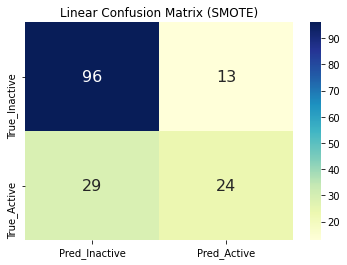

In [25]:
matrix = confusion_matrix(y_test, test_predict)
matrix_df = pd.DataFrame(matrix, index=['True_Inactive', 'True_Active'], columns=['Pred_Inactive', 'Pred_Active'])
ax=sns.heatmap(matrix_df, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'size': 16}).set_title('Linear Confusion Matrix (SMOTE)')
plt.savefig('/content/gdrive/My Drive/linear_smote_matrix.png')
plt.show()

# SVM Classifier

In [26]:
svm = make_pipeline(StandardScaler(), SVC(class_weight='balanced'))
svm.fit(x_train, y_train)
train_predict = svm.predict(x_train)
train_acc = np.mean(train_predict == y_train)
print('Train Accuracy: {:.5f}'.format(train_acc))
val_predict = linear.predict(x_val)
val_acc = np.mean(val_predict == y_val)
print('Val Accuracy: {:.5f}'.format(val_acc))
test_predict = linear.predict(x_test)
test_acc = np.mean(test_predict == y_test)
print('Test Accuracy: {:.5f}'.format(test_acc))
auc = roc_auc_score(y_test, test_predict)
print('AUC Score: {:.5f}'.format(auc))
stats['SVM Classifier'] = [train_acc, val_acc, test_acc, auc]

Train Accuracy: 0.99802
Val Accuracy: 0.98758
Test Accuracy: 0.74074
AUC Score: 0.66678


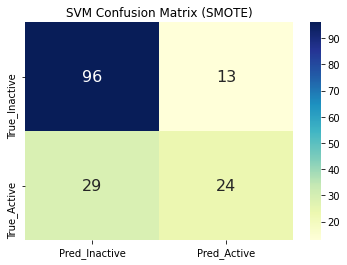

In [27]:
matrix = confusion_matrix(y_test, test_predict)
matrix_df = pd.DataFrame(matrix, index=['True_Inactive', 'True_Active'], columns=['Pred_Inactive', 'Pred_Active'])
ax=sns.heatmap(matrix_df, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'size': 16}).set_title('SVM Confusion Matrix (SMOTE)')
plt.savefig('/content/gdrive/My Drive/svm_smote_matrix.png')
plt.show()

# MLP Model

In [28]:
mlp = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Linear(128, 2)
)
mlp.to(device)
print(mlp)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=256, out_features=128, bias=True)
  (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=128, out_features=2, bias=True)
)


In [29]:
num_epochs = 100

lr = 1e-3
weight_decay = 5e-6
momentum = 0.9

empty_cache = True

In [30]:
batch_size = 32
train_loader, val_loader, test_loader = get_mlp_loader(x_train, y_train, x_val, y_val, x_test, y_test, cuda, batch_size)

In [31]:
optimizer = optim.SGD(mlp.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=1, verbose=True)
criterion = nn.CrossEntropyLoss()

In [32]:
model_name = 'mlp_smote_{}_epochs_{}_lr_{}_wd'.format(num_epochs, lr, weight_decay)
print('Training {}'.format(model_name))
train_losses, train_accuracy, valid_losses, valid_accuracy = train_model(mlp, model_name, train_loader, val_loader, optimizer, criterion, scheduler, device, num_epochs, empty_cache)

Training mlp_smote_100_epochs_0.001_lr_5e-06_wd
Epoch: 1	Learning Rate: 0.001
Epoch: 1	Batch: 50	Avg-Loss: 0.4854	Elapsed Time: 1.0892
Epoch: 1	Batch: 100	Avg-Loss: 0.2228	Elapsed Time: 1.3512
Epoch: 1	Training Time: 1.6389
Epoch: 1	Train Loss: 0.33343	Train Accuracy: 0.87218
Epoch: 1	Validation Time: 1.0447
Epoch: 1	Val Loss: 0.11379	Val Accuracy: 0.97743
Epoch: 2	Learning Rate: 0.001
Epoch: 2	Batch: 50	Avg-Loss: 0.0883	Elapsed Time: 1.0864
Epoch: 2	Batch: 100	Avg-Loss: 0.0583	Elapsed Time: 1.3454
Epoch: 2	Training Time: 1.6084
Epoch: 2	Train Loss: 0.07103	Train Accuracy: 0.99069
Epoch: 2	Validation Time: 1.0338
Epoch: 2	Val Loss: 0.05226	Val Accuracy: 0.98533
Epoch: 3	Learning Rate: 0.001
Epoch: 3	Batch: 50	Avg-Loss: 0.0415	Elapsed Time: 1.0482
Epoch: 3	Batch: 100	Avg-Loss: 0.0407	Elapsed Time: 1.3265
Epoch: 3	Training Time: 1.6076
Epoch: 3	Train Loss: 0.03988	Train Accuracy: 0.99295
Epoch: 3	Validation Time: 1.0227
Epoch: 3	Val Loss: 0.03908	Val Accuracy: 0.98871
Epoch: 4	Learning R

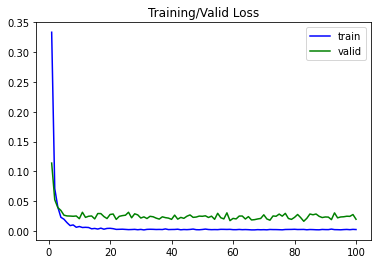

In [33]:
training_plot(train_losses, valid_losses, model_name, 'Loss')

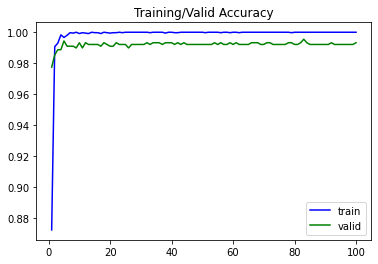

In [34]:
training_plot(train_accuracy, valid_accuracy, model_name, 'Accuracy')

In [35]:
test_loss, test_acc = valid(mlp, test_loader, criterion, device, None, empty_cache)
print('Test Loss: {:.5f}\tTest Accuracy: {:.5f}'.format(test_loss, test_acc))

Final Validation Time: 0.9946
Test Loss: 0.79932	Test Accuracy: 0.82716


In [36]:
accuracy, auc, matrix = test(mlp, test_loader, device, empty_cache)
print('Accuracy: {:.5f}'.format(accuracy))
print('AUC Score: {:.5f}'.format(auc))
stats['MLP Classifier'] = [train_accuracy[-1], valid_accuracy[-1], test_acc, auc]

Testing Time: 0.9616
Accuracy: 0.82716
AUC Score: 0.78432


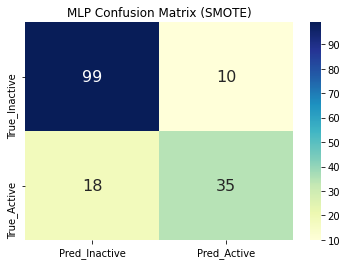

In [37]:
matrix_df = pd.DataFrame(matrix, index=['True_Inactive', 'True_Active'], columns=['Pred_Inactive', 'Pred_Active'])
ax=sns.heatmap(matrix_df, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'size': 16}).set_title('MLP Confusion Matrix (SMOTE)')
plt.savefig('/content/gdrive/My Drive/{}_matrix.png'.format(model_name))
plt.show()

# TDNN With Padding Model

In [38]:
tdnn1 = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=2048, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm1d(2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=2048, out_channels=1024, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.MaxPool1d(2),
    nn.Flatten(),
    nn.Linear(128*32, 2)
)
tdnn1.to(device)
print(tdnn1)

Sequential(
  (0): Conv1d(1, 2048, kernel_size=(3,), stride=(2,), padding=(1,))
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv1d(2048, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Conv1d(1024, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Conv1d(512, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Conv1d(256, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (17): BatchNorm1d(128, eps

In [39]:
num_epochs = 100

lr = 1e-3
weight_decay = 5e-6
momentum = 0.9

start_epoch = 0
train_losses = []
valid_losses = []

empty_cache = True

In [40]:
batch_size = 32
train_loader, val_loader, test_loader = get_tdnn_loader(x_train, y_train, x_val, y_val, x_test, y_test, cuda, batch_size)

In [41]:
optimizer = optim.SGD(tdnn1.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=1, verbose=True)
criterion = nn.CrossEntropyLoss()

In [42]:
model_name = 'tdnn_with_padding_smote_{}_epochs_{}_lr_{}_wd'.format(num_epochs, lr, weight_decay)
print('Training {}'.format(model_name))
train_losses, train_accuracy, valid_losses, valid_accuracy = train_model(tdnn1, model_name, train_loader, val_loader, optimizer, criterion, scheduler, device, num_epochs, empty_cache)

Training tdnn_with_padding_smote_100_epochs_0.001_lr_5e-06_wd
Epoch: 1	Learning Rate: 0.001
Epoch: 1	Batch: 50	Avg-Loss: 0.3727	Elapsed Time: 5.0244
Epoch: 1	Batch: 100	Avg-Loss: 0.1437	Elapsed Time: 9.2471
Epoch: 1	Training Time: 10.4111
Epoch: 1	Train Loss: 0.24390	Train Accuracy: 0.89842
Epoch: 1	Validation Time: 1.7103
Epoch: 1	Val Loss: 0.10096	Val Accuracy: 0.97291
Epoch: 2	Learning Rate: 0.001
Epoch: 2	Batch: 50	Avg-Loss: 0.0796	Elapsed Time: 4.9703
Epoch: 2	Batch: 100	Avg-Loss: 0.0631	Elapsed Time: 9.1919
Epoch: 2	Training Time: 10.3368
Epoch: 2	Train Loss: 0.07017	Train Accuracy: 0.98533
Epoch: 2	Validation Time: 1.7248
Epoch: 2	Val Loss: 0.07567	Val Accuracy: 0.98420
Epoch: 3	Learning Rate: 0.001
Epoch: 3	Batch: 50	Avg-Loss: 0.0389	Elapsed Time: 4.9487
Epoch: 3	Batch: 100	Avg-Loss: 0.0428	Elapsed Time: 9.1626
Epoch: 3	Training Time: 10.3128
Epoch: 3	Train Loss: 0.04049	Train Accuracy: 0.99069
Epoch: 3	Validation Time: 1.7113
Epoch: 3	Val Loss: 0.06947	Val Accuracy: 0.97968
Ep

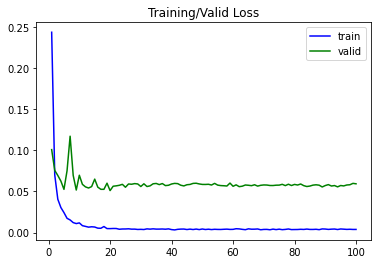

In [43]:
training_plot(train_losses, valid_losses, model_name, 'Loss')

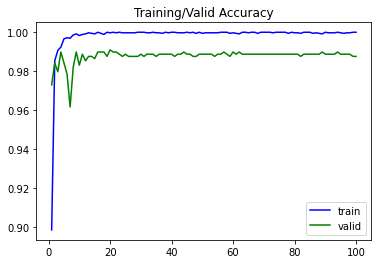

In [44]:
training_plot(train_accuracy, valid_accuracy, model_name, 'Accuracy')

In [45]:
test_loss, test_acc = valid(tdnn1, test_loader, criterion, device, None, empty_cache)
print('Test Loss: {:.5f}\tTest Accuracy: {:.5f}'.format(test_loss, test_acc))

Final Validation Time: 1.1187
Test Loss: 1.02430	Test Accuracy: 0.82716


In [46]:
accuracy, auc, matrix = test(tdnn1, test_loader, device, empty_cache)
print('Accuracy: {:.5f}'.format(accuracy))
print('AUC Score: {:.5f}'.format(auc))
stats['TDNN Classifier with Padding'] = [train_accuracy[-1], valid_accuracy[-1], test_acc, auc]

Testing Time: 1.1411
Accuracy: 0.82716
AUC Score: 0.80370


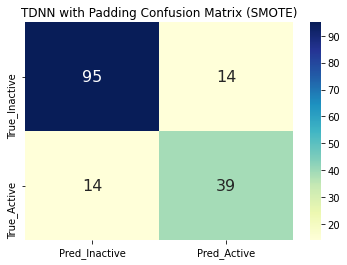

In [47]:
matrix_df = pd.DataFrame(matrix, index=['True_Inactive', 'True_Active'], columns=['Pred_Inactive', 'Pred_Active'])
ax=sns.heatmap(matrix_df, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'size': 16}).set_title('TDNN with Padding Confusion Matrix (SMOTE)')
plt.savefig('/content/gdrive/My Drive/{}_matrix.png'.format(model_name))
plt.show()

# TDNN Without Padding Model

In [48]:
tdnn2 = nn.Sequential(
    nn.Conv1d(in_channels=1, out_channels=2048, kernel_size=2, stride=2),
    nn.BatchNorm1d(2048),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=2048, out_channels=1024, kernel_size=2, stride=2),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.Conv1d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.1),
    nn.MaxPool1d(2),
    nn.Flatten(),
    nn.Linear(128*32, 2)
)
tdnn2.to(device)
print(tdnn2)

Sequential(
  (0): Conv1d(1, 2048, kernel_size=(2,), stride=(2,))
  (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv1d(2048, 1024, kernel_size=(2,), stride=(2,))
  (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Conv1d(1024, 512, kernel_size=(2,), stride=(2,))
  (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Conv1d(512, 256, kernel_size=(2,), stride=(2,))
  (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Conv1d(256, 128, kernel_size=(2,), stride=(2,))
  (17): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): R

In [49]:
num_epochs = 100

lr = 1e-3
weight_decay = 5e-6
momentum = 0.9

start_epoch = 0
train_losses = []
valid_losses = []

empty_cache = True

In [50]:
batch_size = 32
train_loader, val_loader, test_loader = get_tdnn_loader(x_train, y_train, x_val, y_val, x_test, y_test, cuda, batch_size)

In [51]:
optimizer = optim.SGD(tdnn2.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=1, verbose=True)
criterion = nn.CrossEntropyLoss()

In [52]:
model_name = 'tdnn_without_padding_smote_{}_epochs_{}_lr_{}_wd'.format(num_epochs, lr, weight_decay)
print('Training {}'.format(model_name))
train_losses, train_accuracy, valid_losses, valid_accuracy = train_model(tdnn2, model_name, train_loader, val_loader, optimizer, criterion, scheduler, device, num_epochs, empty_cache)

Training tdnn_without_padding_smote_100_epochs_0.001_lr_5e-06_wd
Epoch: 1	Learning Rate: 0.001
Epoch: 1	Batch: 50	Avg-Loss: 0.3820	Elapsed Time: 4.2389
Epoch: 1	Batch: 100	Avg-Loss: 0.1570	Elapsed Time: 7.7379
Epoch: 1	Training Time: 8.7483
Epoch: 1	Train Loss: 0.25435	Train Accuracy: 0.88826
Epoch: 1	Validation Time: 1.5508
Epoch: 1	Val Loss: 0.11843	Val Accuracy: 0.96840
Epoch: 2	Learning Rate: 0.001
Epoch: 2	Batch: 50	Avg-Loss: 0.0933	Elapsed Time: 4.1957
Epoch: 2	Batch: 100	Avg-Loss: 0.0732	Elapsed Time: 7.6878
Epoch: 2	Training Time: 8.6797
Epoch: 2	Train Loss: 0.08595	Train Accuracy: 0.97714
Epoch: 2	Validation Time: 1.5734
Epoch: 2	Val Loss: 0.08081	Val Accuracy: 0.98081
Epoch: 3	Learning Rate: 0.001
Epoch: 3	Batch: 50	Avg-Loss: 0.0529	Elapsed Time: 4.2090
Epoch: 3	Batch: 100	Avg-Loss: 0.0583	Elapsed Time: 7.6942
Epoch: 3	Training Time: 8.6881
Epoch: 3	Train Loss: 0.05664	Train Accuracy: 0.98730
Epoch: 3	Validation Time: 1.5659
Epoch: 3	Val Loss: 0.07905	Val Accuracy: 0.98081
Ep

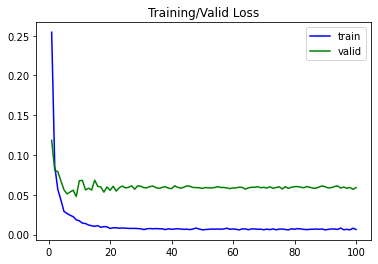

In [53]:
training_plot(train_losses, valid_losses, model_name, 'Loss')

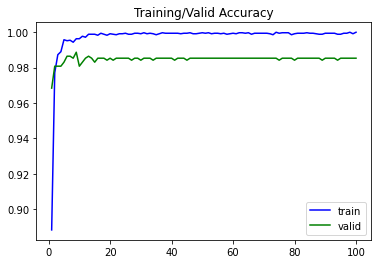

In [54]:
training_plot(train_accuracy, valid_accuracy, model_name, 'Accuracy')

In [55]:
test_loss, test_acc = valid(tdnn2, test_loader, criterion, device, None, empty_cache)
print('Test Loss: {:.5f}\tTest Accuracy: {:.5f}'.format(test_loss, test_acc))

Final Validation Time: 1.0789
Test Loss: 0.98742	Test Accuracy: 0.81481


In [56]:
accuracy, auc, matrix = test(tdnn2, test_loader, device, empty_cache)
print('Accuracy: {:.5f}'.format(accuracy))
print('AUC Score: {:.5f}'.format(auc))
stats['TDNN Classifier without Padding'] = [train_accuracy[-1], valid_accuracy[-1], test_acc, auc]

Testing Time: 1.0745
Accuracy: 0.81481
AUC Score: 0.78484


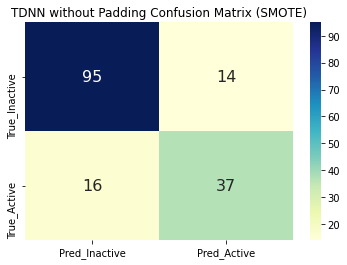

In [57]:
matrix_df = pd.DataFrame(matrix, index=['True_Inactive', 'True_Active'], columns=['Pred_Inactive', 'Pred_Active'])
ax=sns.heatmap(matrix_df, cmap='YlGnBu', annot=True, fmt='d', annot_kws={'size': 16}).set_title('TDNN without Padding Confusion Matrix (SMOTE)')
plt.savefig('/content/gdrive/My Drive/{}_matrix.png'.format(model_name))
plt.show()

#Summary

In [58]:
stats_df = pd.DataFrame(stats, index=['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy', 'AUC Score'])
stats_df.to_csv('/content/gdrive/My Drive/smote_result.csv')

In [59]:
stats_df

,Linear Classifier,SVM Classifier,MLP Classifier,TDNN Classifier with Padding,TDNN Classifier without Padding
Training Accuracy,0.997743,0.998025,1.000000,1.000000,1.000000
Validation Accuracy,0.987585,0.987585,0.993228,0.987585,0.985327
Testing Accuracy,0.740741,0.740741,0.827160,0.827160,0.814815
AUC Score,0.666782,0.666782,0.784317,0.803704,0.784836
